# Data Exploration

In [1]:
import pandas as pd

# 1. [CDD-CESM] Categorized Digital Database for Low energy and Subtracted Contrast Enhanced Spectral Mammography images - 1.5G , 2006 images

https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=109379611

## From annotations files:

In [2]:
cdd_cesm_df = pd.read_csv('input/CDD-CESM/Radiology_hand_drawn_segmentations_v2.csv')
cdd_cesm_df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,P1_L_CM_MLO.jpg,939216,{},1,0,"{""name"":""polygon"",""all_points_x"":[350,423,1005...",{}
1,P1_L_DM_MLO.jpg,646195,{},1,0,"{""name"":""polygon"",""all_points_x"":[353,413,1033...",{}
2,P2_L_CM_CC.jpg,302172,{},1,0,"{""name"":""polygon"",""all_points_x"":[550,533,412,...",{}
3,P2_L_CM_MLO.jpg,348629,{},1,0,"{""name"":""polygon"",""all_points_x"":[26,954,945,8...",{}
4,P2_L_DM_CC.jpg,572664,{},4,0,"{""name"":""polygon"",""all_points_x"":[4,107,349,49...",{}


In [3]:
cdd_cesm_df_xlsx = pd.read_excel('input/CDD-CESM/annotations.xlsx', engine='openpyxl')
cdd_cesm_df_xlsx.head()

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,Machine,Pathology Classification/ Follow up
0,P1_L_DM_MLO,1,L,DM,46,C,4,Architectural distortion,MLO,"suspicious, distortion",1,Malignant
1,P1_L_CM_MLO,1,L,CESM,46,_,4,Heterogenous non mass enhancement,MLO,"suspicious, non mass",1,Malignant
2,P2_R_DM_CC,2,R,DM,31,C,3$2,Multiple equal density masses$Benign macrocal...,CC,"benign, masses, macrocalcification",2,Benign
3,P2_R_DM_MLO,2,R,DM,31,C,3$2,Multiple equal density masses$Benign macrocalc...,MLO,"benign, masses, macrocalcification",2,Benign
4,P2_R_CM_CC,2,R,CESM,31,_,3,Multiple homogenously enhancing masses,CC,"benign, masses, homogenous",2,Benign


In [4]:
cdd_cesm_df_xlsx['Pathology Classification/ Follow up'].unique()

array(['Malignant', 'Benign', 'Normal'], dtype=object)

In [5]:
cdd_cesm_df_xlsx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Image_name                           2006 non-null   object
 1   Patient_ID                           2006 non-null   int64 
 2   Side                                 2006 non-null   object
 3   Type                                 2006 non-null   object
 4   Age                                  2006 non-null   int64 
 5   Breast density (ACR)                 2006 non-null   object
 6   BIRADS                               2006 non-null   object
 7   Findings                             2006 non-null   object
 8   View                                 2006 non-null   object
 9   Tags                                 2006 non-null   object
 10  Machine                              2006 non-null   int64 
 11  Pathology Classification/ Follow up  2006 n

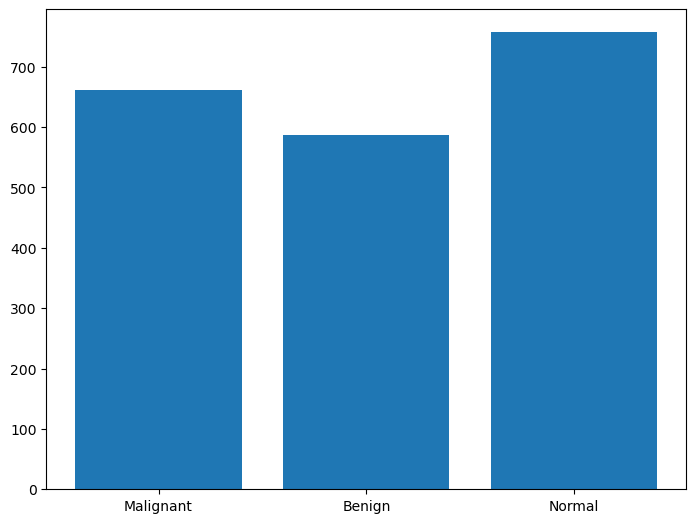

In [6]:
maligant_n = cdd_cesm_df_xlsx[cdd_cesm_df_xlsx['Pathology Classification/ Follow up']=='Malignant'].count()[0]
benign_n = cdd_cesm_df_xlsx[cdd_cesm_df_xlsx['Pathology Classification/ Follow up']=='Benign'].count()[0]
normal_n = cdd_cesm_df_xlsx[cdd_cesm_df_xlsx['Pathology Classification/ Follow up']=='Normal'].count()[0]
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Malignant', 'Benign', 'Normal']
nums = [maligant_n, benign_n, normal_n]
ax.bar(labels, nums)
plt.show()

## From images:

In [7]:
import os
print(os.listdir("input"))


['.DS_Store', 'CDD-CESM', 'CMMD']


In [8]:
from os import walk
for (dirpath, dirnames, filenames) in walk("input/CDD-CESM/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

Directory path:  input/CDD-CESM/
Folder name:  ['SubtractedImages', 'LowEnergyImages', '.ipynb_checkpoints']
Directory path:  input/CDD-CESM/SubtractedImages
Folder name:  []
Directory path:  input/CDD-CESM/LowEnergyImages
Folder name:  ['.ipynb_checkpoints']
Directory path:  input/CDD-CESM/LowEnergyImages/.ipynb_checkpoints
Folder name:  []
Directory path:  input/CDD-CESM/.ipynb_checkpoints
Folder name:  []


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [11]:
transform = transforms.Compose([transforms.Resize((255,255)),
                                 transforms.ToTensor()])
dataset = datasets.ImageFolder('input/CDD-CESM', transform=transform)

In [22]:
dataset.imgs[0]

('input/CDD-CESM/LowEnergyImages/P100_L_DM_CC.jpg', 1)

In [23]:
len(dataset.imgs)

2008

In [32]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

In [33]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

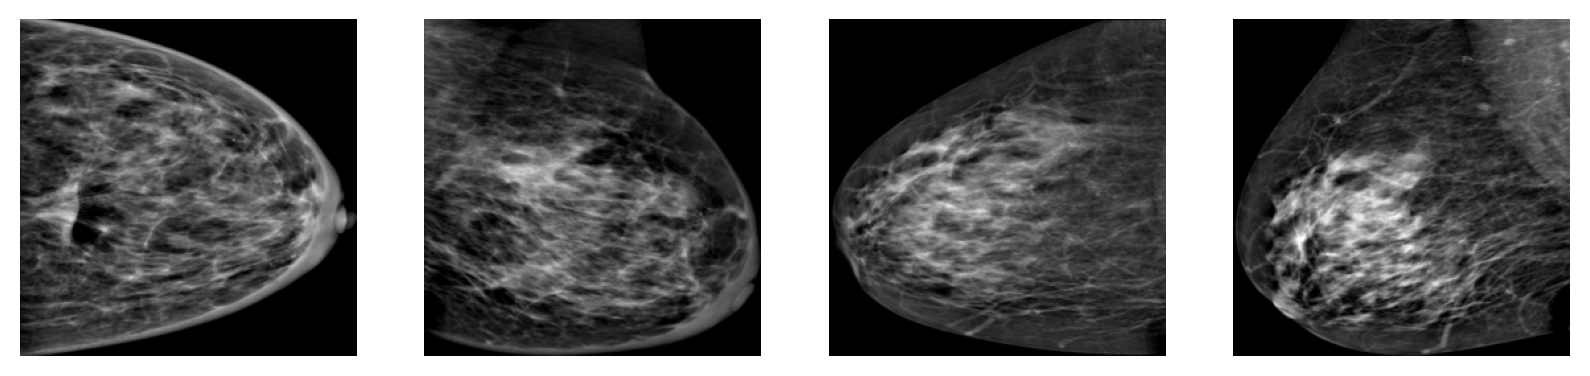

In [17]:
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

In [29]:
import glob
import re
import os
import cv2

images = []
file_names = []
regex = re.compile(r'/([A-Za-z0-9_]+)\.jpg')

for name in glob.glob('input/CDD-CESM/SubtractedImages/*'):
    #print(name)
    result = regex.findall(name)
    file_names.append(result)
    
print(len(file_names))

for name in glob.glob('input/CDD-CESM/LowEnergyImages/*'):
    #print(name)
    result = regex.findall(name)
    file_names.append(result)

print(len(file_names))
print(file_names[0])
print(file_names[1])

1003
2006
['P256_L_CM_MLO']
['P46_R_CM_MLO']


# 2. The Chinese Mammography Database (CMMD) - 22.8G , 5202 images

https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70230508#702305080c14f046035746908389905a1259f4c6

## From xlsl file:

In [24]:
cmmd_df = pd.read_excel('input/CMMD/CMMD_clinicaldata_revision.xlsx', engine='openpyxl')

In [25]:
cmmd_df.head(-10)

,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,Benign,NaN
1,D1-0002,L,40,2,calcification,Benign,NaN
2,D1-0003,L,39,2,calcification,Benign,NaN
3,D1-0004,L,41,2,calcification,Benign,NaN
4,D1-0005,R,42,2,calcification,Benign,NaN
...,...,...,...,...,...,...,...
1857,D2-0735,L,48,2,mass,Malignant,Luminal B
1858,D2-0736,R,48,2,mass,Malignant,Luminal A
1859,D2-0737,R,44,2,mass,Malignant,Luminal B
1860,D2-0738,R,43,2,mass,Malignant,HER2-enriched


In [26]:
print(cmmd_df['classification'].unique())
print(cmmd_df['number'].unique())

['Benign' 'Malignant']
[2]


In [27]:
cmmd_df["classification"] = np.where(cmmd_df["classification"] == "Benign", 0, 1)
print(cmmd_df['classification'].unique())
cmmd_df.head(-10)

[0 1]


,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,0,NaN
1,D1-0002,L,40,2,calcification,0,NaN
2,D1-0003,L,39,2,calcification,0,NaN
3,D1-0004,L,41,2,calcification,0,NaN
4,D1-0005,R,42,2,calcification,0,NaN
...,...,...,...,...,...,...,...
1857,D2-0735,L,48,2,mass,1,Luminal B
1858,D2-0736,R,48,2,mass,1,Luminal A
1859,D2-0737,R,44,2,mass,1,Luminal B
1860,D2-0738,R,43,2,mass,1,HER2-enriched


## From images:

In [18]:
#!pip install pydicom

  Using cached pydicom-2.3.0-py3-none-any.whl (2.0 MB)


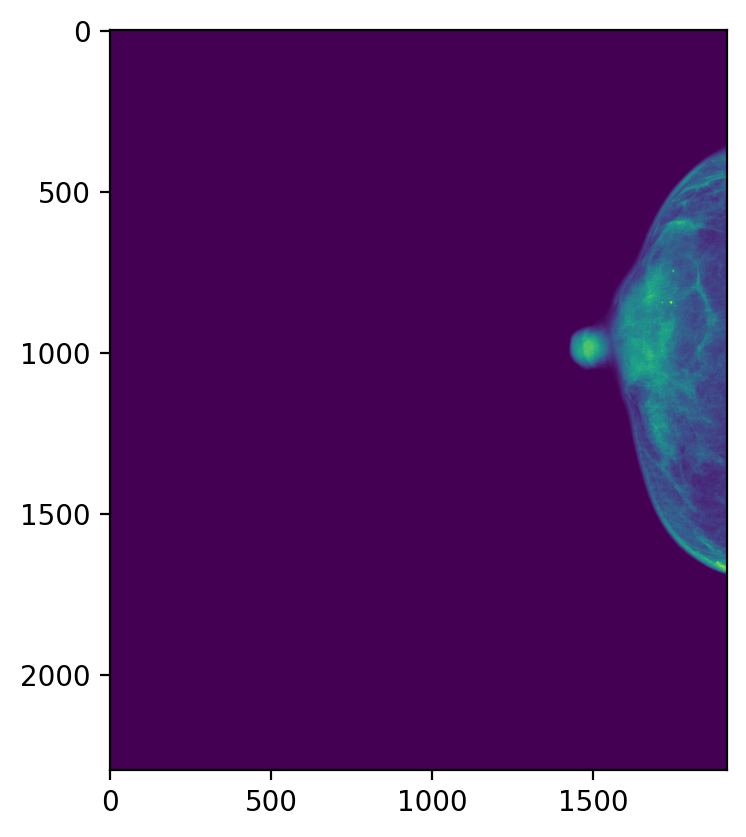

In [19]:
import pydicom as dicom
import matplotlib.pylab as plt

# specify your image path
image_path = 'input/CMMD/data/manifest-1663098686378/CMMD/D1-0001/07-18-2010-NA-NA-79377/1.000000-NA-70244/1-1.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array)

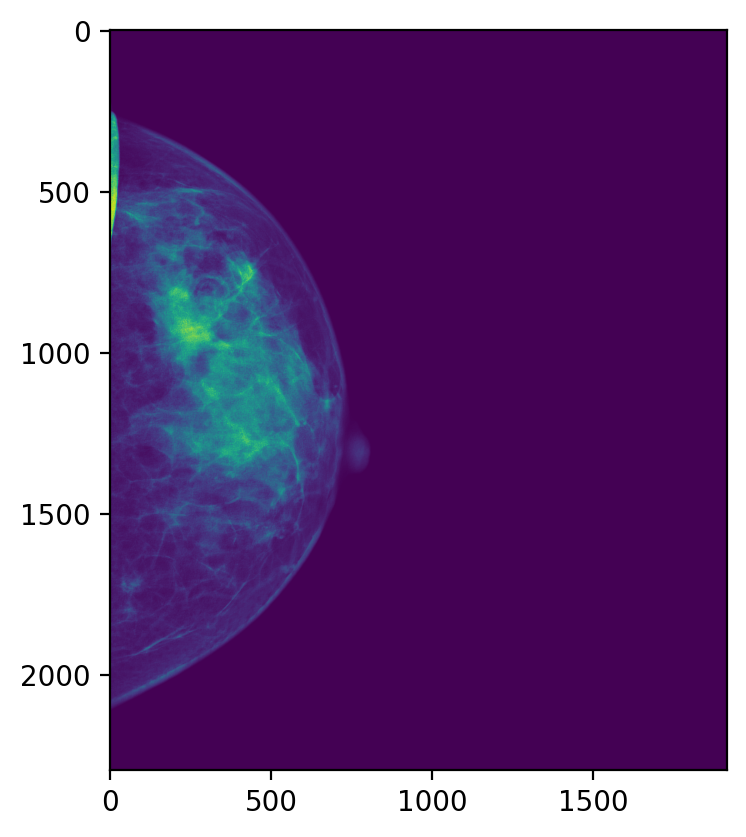

In [33]:
image_path = "input/CMMD/data/manifest-1663098686378/CMMD/D2-0749/07-17-2012-NA-NA-85032/1.000000-NA-15082/1-1.dcm"
ds = dicom.dcmread(image_path)
plt.imshow(ds.pixel_array)

In [30]:
i
for i, row in cmmd_df.iterrows():
    if (row['classification']==0) :
        
    break;
                   

0


In [38]:
import glob

for name in glob.glob('input/CMMD/data/manifest-1663098686378/CMMD/**/**/**/*.dcm'):
    print(name)

input/CMMD/data/manifest-1663098686378/CMMD/D1-0003/07-18-2011-NA-NA-25491/1.000000-NA-24283/1-2.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0003/07-18-2011-NA-NA-25491/1.000000-NA-24283/1-1.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0004/07-18-2011-NA-NA-14914/1.000000-NA-36301/1-2.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0004/07-18-2011-NA-NA-14914/1.000000-NA-36301/1-1.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0005/07-18-2011-NA-NA-52347/1.000000-NA-77249/1-2.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0005/07-18-2011-NA-NA-52347/1.000000-NA-77249/1-1.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0002/07-18-2010-NA-NA-49231/1.000000-NA-45313/1-2.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D1-0002/07-18-2010-NA-NA-49231/1.000000-NA-45313/1-1.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D2-0746/07-18-2011-NA-NA-61307/1.000000-NA-36363/1-3.dcm
input/CMMD/data/manifest-1663098686378/CMMD/D2-0746/07-18-2011-NA-NA-61307/1.000000-NA-3636